<h1><center>Artificial Neural Networks</h1>

## Imports

In [1]:
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score, roc_auc_score
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import plot_model

In [2]:
df = pd.read_csv("./dataset/heart.csv")

## Preprocessing

In [3]:
# Encode categorical features
label_encoder = LabelEncoder()
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])


In [4]:
# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']


In [5]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


# hyperparameter tuning function

In [6]:
def objective(trial):
    # Define search space for hyperparameters
    num_layers = trial.suggest_int('num_layers', 2, 4)
    num_units = trial.suggest_int('num_units', 16, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 7e-3)
    
    # Build ANN model
    model = Sequential()
    model.add(Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train model with early stopping
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # Evaluate model on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    
    return val_acc



In [7]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Get best hyperparameters
best_params = study.best_params



[I 2024-05-24 11:11:53,867] A new study created in memory with name: no-name-e833b871-bed2-441f-8cba-fbb7ce614a2c


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\byomo\AppData\Local\Temp\ipykernel_17052\4191093952.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 7e-3)


[I 2024-05-24 11:11:57,903] Trial 0 finished with value: 0.9202898740768433 and parameters: {'num_layers': 4, 'num_units': 118, 'learning_rate': 0.0016441767402548138}. Best is trial 0 with value: 0.9202898740768433.
[I 2024-05-24 11:12:00,743] Trial 1 finished with value: 0.8840579986572266 and parameters: {'num_layers': 3, 'num_units': 79, 'learning_rate': 0.0018325048958047763}. Best is trial 0 with value: 0.9202898740768433.
[I 2024-05-24 11:12:03,092] Trial 2 finished with value: 0.9275362491607666 and parameters: {'num_layers': 3, 'num_units': 87, 'learning_rate': 0.004418258946126452}. Best is trial 2 with value: 0.9275362491607666.
[I 2024-05-24 11:12:05,558] Trial 3 finished with value: 0.9275362491607666 and parameters: {'num_layers': 2, 'num_units': 100, 'learning_rate': 0.005944934855956061}. Best is trial 2 with value: 0.9275362491607666.
[I 2024-05-24 11:12:07,885] Trial 4 finished with value: 0.8985507488250732 and parameters: {'num_layers': 2, 'num_units': 70, 'learning

## Training

In [8]:
# Train final model with best hyperparameters
final_model = Sequential()
for _ in range(best_params['num_layers']):
    final_model.add(Dense(best_params['num_units'], activation='relu', input_shape=(X_train.shape[1],)))

final_model.add(Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

final_model.fit(X_train, y_train, epochs=15, batch_size=48, verbose=1, validation_data=(X_val, y_val))

# Evaluate final model on test set
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_acc)

# Predict on test set
y_pred_probs = final_model.predict(X_test)
y_pred = np.round(y_pred_probs).astype(int)



Epoch 1/15
14/14 [==============================] - 2s 29ms/step - loss: 0.4948 - accuracy: 0.7882 - val_loss: 0.3341 - val_accuracy: 0.8768
Epoch 2/15
14/14 [==============================] - 0s 17ms/step - loss: 0.3503 - accuracy: 0.8692 - val_loss: 0.3213 - val_accuracy: 0.8623
Epoch 3/15
14/14 [==============================] - 0s 6ms/step - loss: 0.3152 - accuracy: 0.8707 - val_loss: 0.2841 - val_accuracy: 0.8841
Epoch 4/15
14/14 [==============================] - 0s 9ms/step - loss: 0.2839 - accuracy: 0.8738 - val_loss: 0.2767 - val_accuracy: 0.8986
Epoch 5/15
14/14 [==============================] - 0s 8ms/step - loss: 0.2667 - accuracy: 0.8879 - val_loss: 0.2935 - val_accuracy: 0.8841
Epoch 6/15
14/14 [==============================] - 0s 7ms/step - loss: 0.2512 - accuracy: 0.8956 - val_loss: 0.2971 - val_accuracy: 0.8841
Epoch 7/15
14/14 [==============================] - 0s 5ms/step - loss: 0.2498 - accuracy: 0.9034 - val_loss: 0.3024 - val_accuracy: 0.9058
Epoch 8/15
14/14 [

## Results

In [9]:
# Calculate additional performance metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
accuracy= accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
f1 = f1_score(y_test, y_pred, average='binary')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8695652173913043
Precision: 0.891566265060241
Recall: 0.891566265060241
F1 Score: 0.891566265060241
ROC AUC Score: 0.9097480832420591


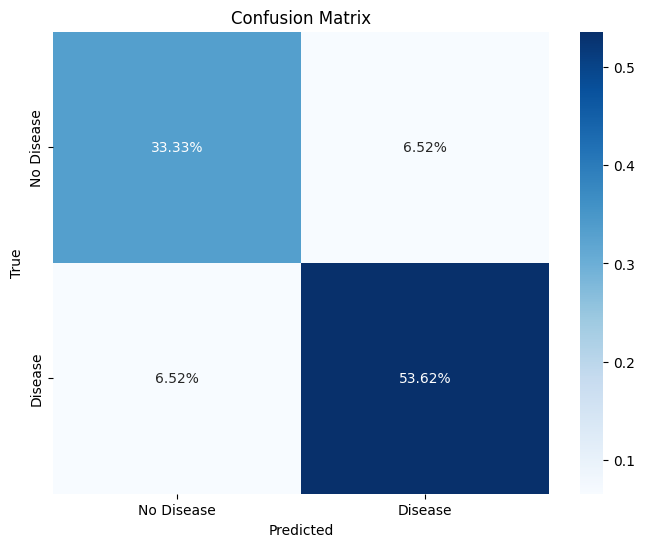

In [10]:
# Plot the confusion matrix using seaborn for better visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# Print model architecture
final_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 87)                1044      
                                                                 
 dense_101 (Dense)           (None, 87)                7656      
                                                                 
 dense_102 (Dense)           (None, 87)                7656      
                                                                 
 dense_103 (Dense)           (None, 1)                 88        
                                                                 
Total params: 16,444
Trainable params: 16,444
Non-trainable params: 0
_________________________________________________________________


## Saving the Model

In [12]:
'''# Save the model
final_model.save('./models/ANN.h5')'''


In [21]:
y_pred_probs = final_model.predict(X)
y_pred = np.round(y_pred_probs).astype(int)

29/29 [==============================] - 0s 2ms/step


In [47]:

ann_accuracy = accuracy_score(y, y_pred)
print("ANN Accuracy:", ann_accuracy)


ANN Accuracy: 0.9400871459694989


In [23]:
y_pred.shape

(918, 1)